## Notebook overview
This notebook builds the basis of the figures in
* Fig. 4E
* Fig. S7
* Fig. S8

From Moses *et al.* (1)


[Moses, D., Yu, F., Ginell, G., Shamoon, N.M., Koenig, P.S., Holehouse, A.S., and Sukenik, S. (2020). Probing the Hidden Sensitivity of Intrinsically Disordered Proteins to their Chemical Environment.](https://www.biorxiv.org/content/10.1101/2020.08.17.252478v1)



In [1]:
import pandas as pd
from analytical_model import energytochi
from analytical_model import chi2nu
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

RG_PREFACTOR = 0.5

# define the mode to be used (can be 'RE' or 'RG')
R = 'RE' 
if R =='RG':
    PREFACTOR = RG_PREFACTOR
elif R=='RE':
    PREFACTOR = RG_PREFACTOR*np.sqrt(6)
else:
    raise Exception('"R" must be either RG or RE')

    
## Read in all the experimental data
all = pd.read_csv('data/chi_all_idrs_all_solutes.csv')


## Setup and prepare for figure generation
The following set of cells build up data structures that are going to be used for data fitting

In [3]:
# get non-redundant set of solvent names and idr names
all_solvents = all['sol'].drop_duplicates()
all_idrs = all['idr'].drop_duplicates()
idr_lens = {}

# define IDR lengths  for downstream analysis
idr_lens['GS8'] = 16
idr_lens['GS16'] = 32
idr_lens['GS24'] = 48
idr_lens['GS32'] = 64
idr_lens['PUMA'] = len('VEEEEWAREIGAQLRRIADDLNAQYERRRQEEQH')
idr_lens['E1A'] = len('MRHIICHGGVITEEMAASLLDQLIEEVLADNLPPPSHFEP')
idr_lens['P53'] = len('MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPD')
idr_lens['Ash1'] = len('GASASSSPSPSTPTKSGKMRSRSSSPVRPKAYTPSPRSPNYHRFALDSPPQSPRRSSNSSITKKGSRRSSGSSPTRHTTRVCV')

## Build dictionary of sequence-to-molecular weights

In [7]:
solute_mass = {}

for s in all_solvents:
    x = all.loc[all['sol'] == s]
    solute_mass[s] = np.array(x['mw (g/mol)'].drop_duplicates())[0]

print('TEST MESSAGE: Mass of urea is: %3.3f mw (g/mol)' % solute_mass['Urea'])

TEST MESSAGE: Mass of urea is: 60.060 mw (g/mol)


## Build functions for manipulating experimental data

In [8]:
def get_conc_chi(idrname, solute):
    """
    Function that returns the concentration, chi value for a given IDR and solute
    as a 2d numpy array
        
    """
    return np.array(all.loc[(all['idr'] == idrname) & (all['sol'] == solute)][['conc','chi']])



def get_molkg_chi(idrname, solute):
    """
    Function that returns the concentration, chi value for a given IDR and solute
    as a 2d numpy array
        
    """
    return np.array(all.loc[(all['idr'] == idrname) & (all['sol'] == solute)][['mol/kg','chi']])
    

## Set up
First pull out of dataframes into dictionaries to make more trivial to play with. 

In [9]:
all_data = {}
all_data_molkg = {}

# for each disordered region
for i in all_idrs:
    
    # initialize empty dictionaries
    if i not in all_data:
        all_data[i] = {}
        all_data_molkg[i] = {}
        
    # for each solvent
    for s in all_solvents:
        
        # Urea and GuHCl are in molar so have to convert into weight percentage!
        if s in ['Urea','GuHCl','NaCl','KCl']:
            tmp = get_conc_chi(i,s)
            tmp_molar_conc = tmp.transpose()[0]
            tmp_chi = tmp.transpose()[1]
            
            # 18*55 = g/mol of water [18] * molarity of pure water (55M)
            # = mass of water in grams in 1 mol
            weight_vol_conc = 100*tmp_molar_conc*solute_mass[s]/(18*55)
            
            all_data[i][s] = np.array([weight_vol_conc, tmp_chi]).transpose()
            
            
            
        else:
            all_data[i][s] = get_conc_chi(i,s)
            
        all_data_molkg[i][s] = get_molkg_chi(i,s)

# build a list with all solvents EXCEPT NaCl/KCl becuase when we start 
# at 0 NaCl/KCl it's different to zero for other exogenous solutes
all_solvents_no_salt = []
for s in all_solvents:
    if s not in ['NaCl', 'KCl']:            
            all_solvents_no_salt.append(s)
        

### Check spacing is always equal
The code below is a sanity check to ensure spacing betweens solution points is the same. Note that even if it wasn't we could still make the analysis work, but the even spacing does make things a bit easier to deal with. This should NOT show any WARNING signs but we include it here for completeness!

In [12]:

check_flag = False
for i in all_idrs:
    for s in all_solvents_no_salt:
        
        # if spacing between points is the same this value is ~0
        summed_secondary_diff = sum(np.diff(np.diff(all_data[i][s].transpose()[0])))
        
        if summed_secondary_diff > 1e-10:
            print('WARNING: %s as %s is not evenly spaced'%(i,s))
            check_flag=True
            
if check_flag is False:
    print('Even spacing of solutes checked and valid!')
            


Even spacing of solutes checked and valid!


## Function bank
Set of functions we're going to use for fitting experimental data to our analytical model

In [13]:
def evaluate(real_chi, proposed_e, L):    
    total = 0
    for idx in range(len(proposed_e)):
        theory_chi = energytochi(proposed_e[idx], L,PREFACTOR)
        total = total + abs(theory_chi - real_chi[idx])
    return total


def fit_start_energy(start_chi, L):
    best = 10000
    best_start = None
    for start in np.arange(-0.4, 0.4, 0.001):        
        ev = abs(energytochi(start,L, PREFACTOR) - start_chi)
        
        if ev < best:
            best = ev
            best_start = start
            
    return best_start
    
        
def fit_exp_chi_to_energy(chi_val, L, start):
    
    best = 100000
    best_delta = None
    n_vals = len(chi_val)
    
    for delta in np.arange(-0.02, 0.02, 0.0005):
        
        v = start + np.arange(n_vals)*delta    
        ev = evaluate(chi_val, v, L)
        #print('%1.4f, %1.3f' %(, delta, ev))
        if ev < best:
            #print(delta)
            best = ev
            best_delta = delta

    v = start + np.arange(n_vals)*best_delta
                                    
    return (best_delta, v)



### Plot everything (panels for Fig. 4E, and Fig. 

GS8 => -0.4: 0.316
GS8 => -0.2: 0.420
GS8 => +0.2: 0.566
GS8 => +0.4: 0.621
GS16 => -0.4: 0.353
GS16 => -0.2: 0.436
GS16 => +0.2: 0.553
GS16 => +0.4: 0.597
GS24 => -0.4: 0.368
GS24 => -0.2: 0.442
GS24 => +0.2: 0.547
GS24 => +0.4: 0.587
GS32 => -0.4: 0.377
GS32 => -0.2: 0.446
GS32 => +0.2: 0.544
GS32 => +0.4: 0.581
PUMA => -0.4: 0.355
PUMA => -0.2: 0.437
PUMA => +0.2: 0.552
PUMA => +0.4: 0.595
E1A => -0.4: 0.362
E1A => -0.2: 0.440
E1A => +0.2: 0.549
E1A => +0.4: 0.591
P53 => -0.4: 0.376
P53 => -0.2: 0.446
P53 => +0.2: 0.544
P53 => +0.4: 0.582
Ash1 => -0.4: 0.384
Ash1 => -0.2: 0.450
Ash1 => +0.2: 0.541
Ash1 => +0.4: 0.576


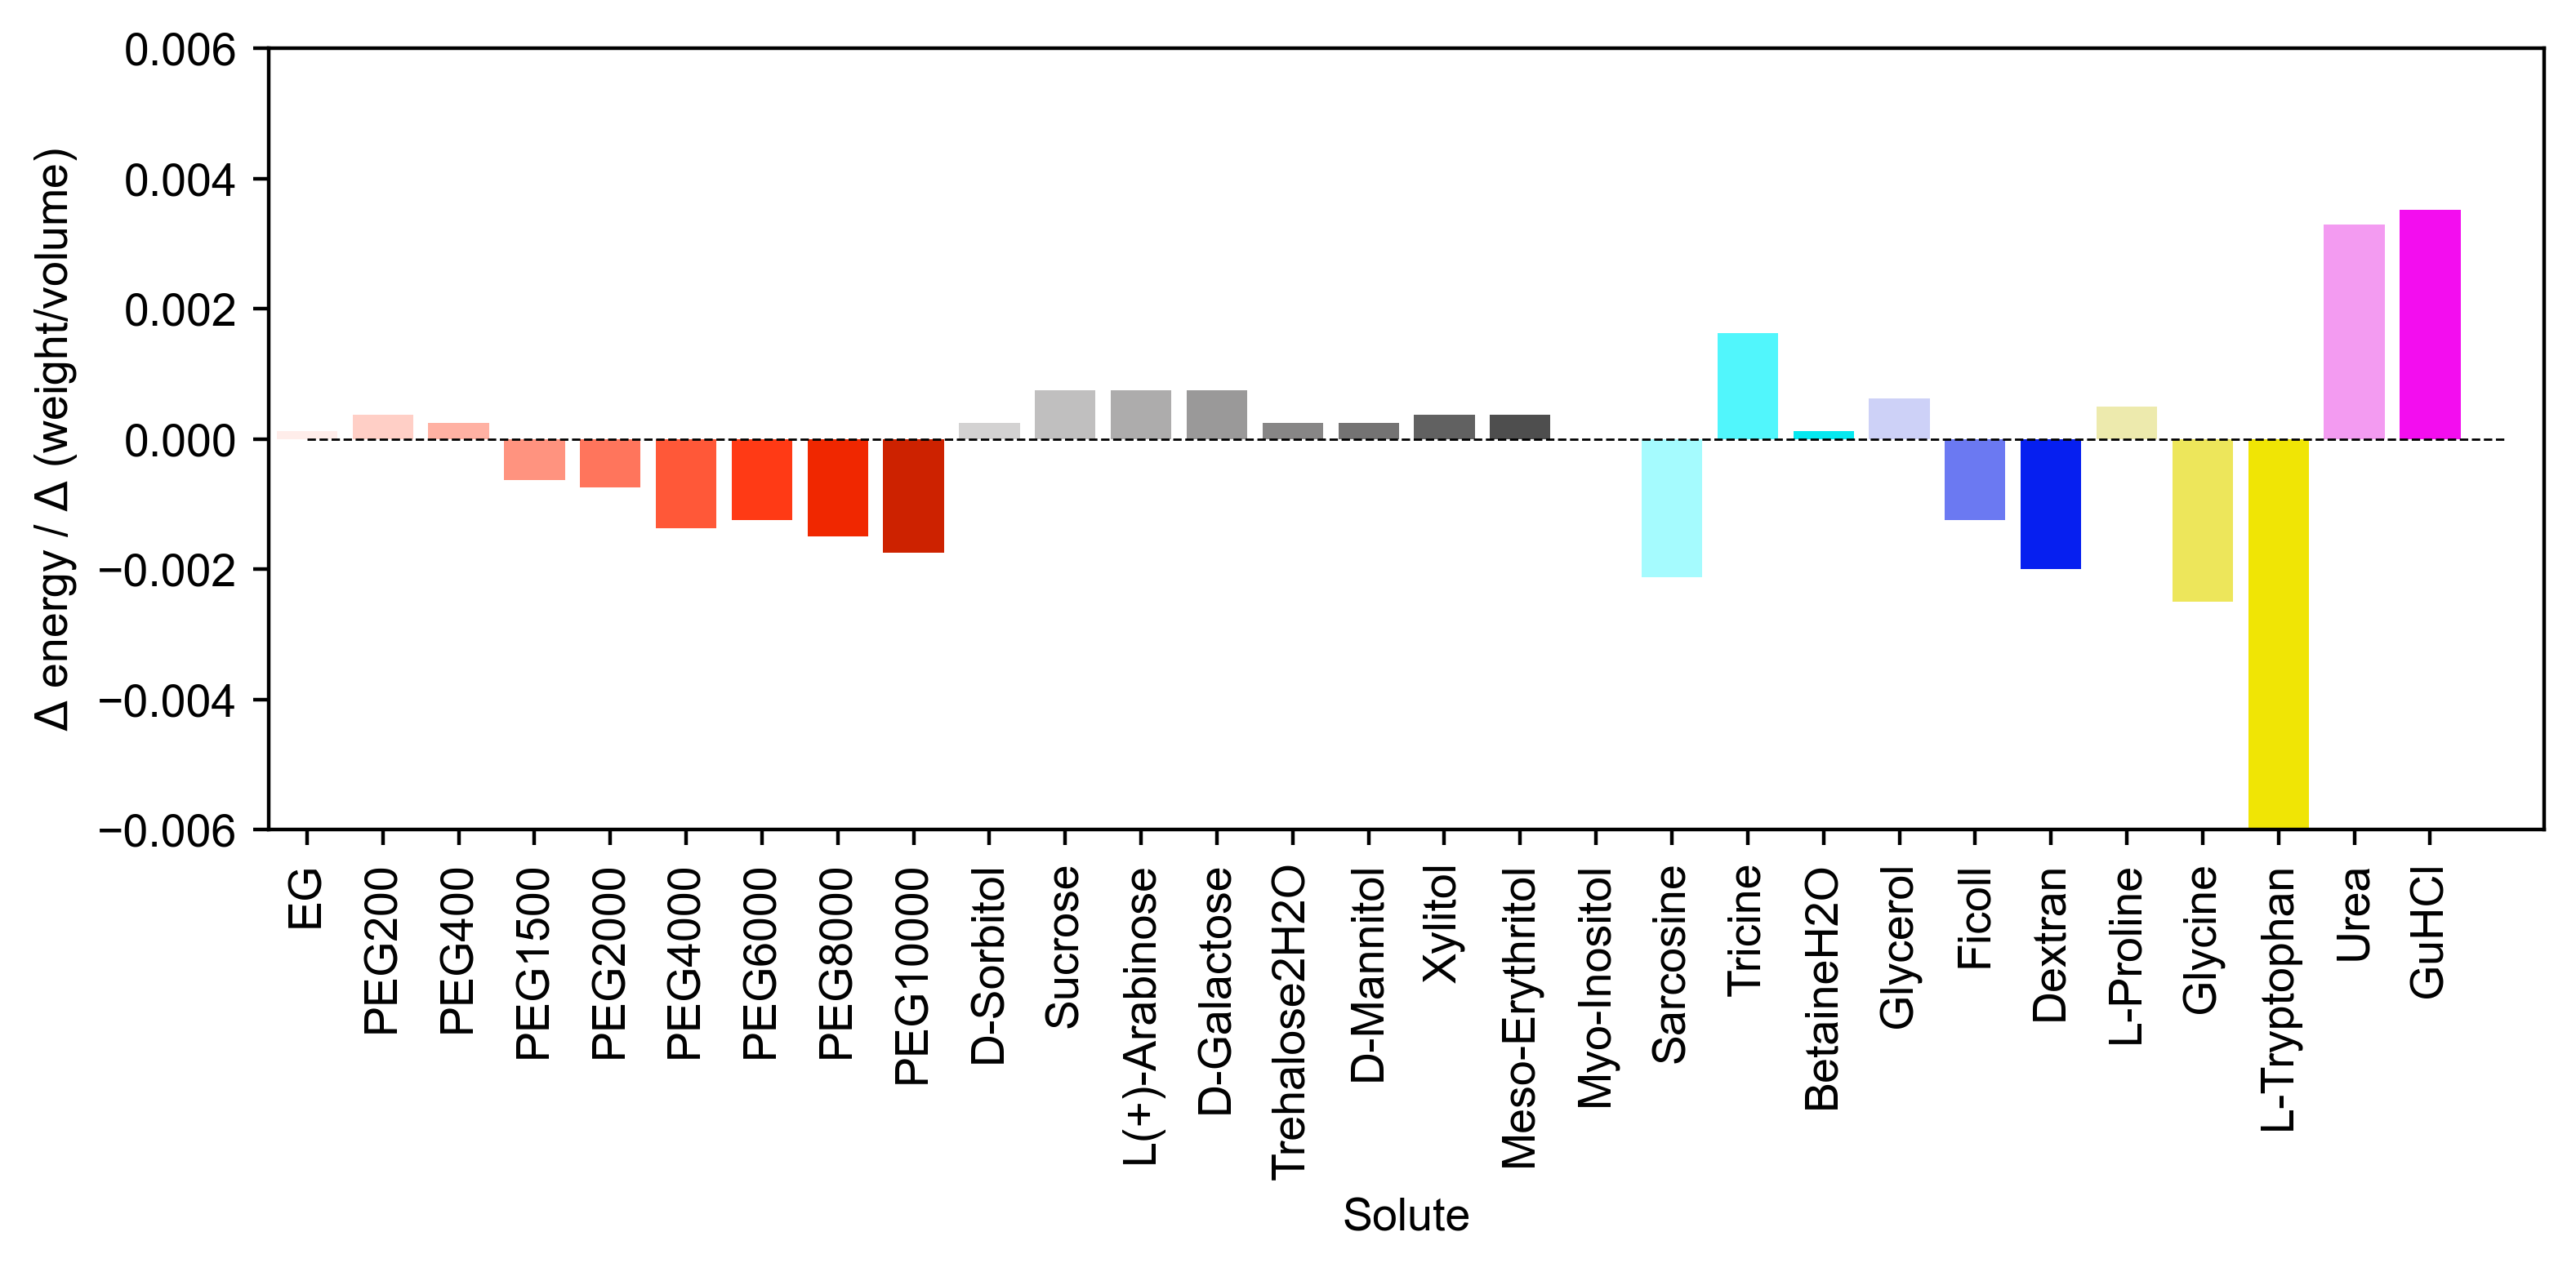

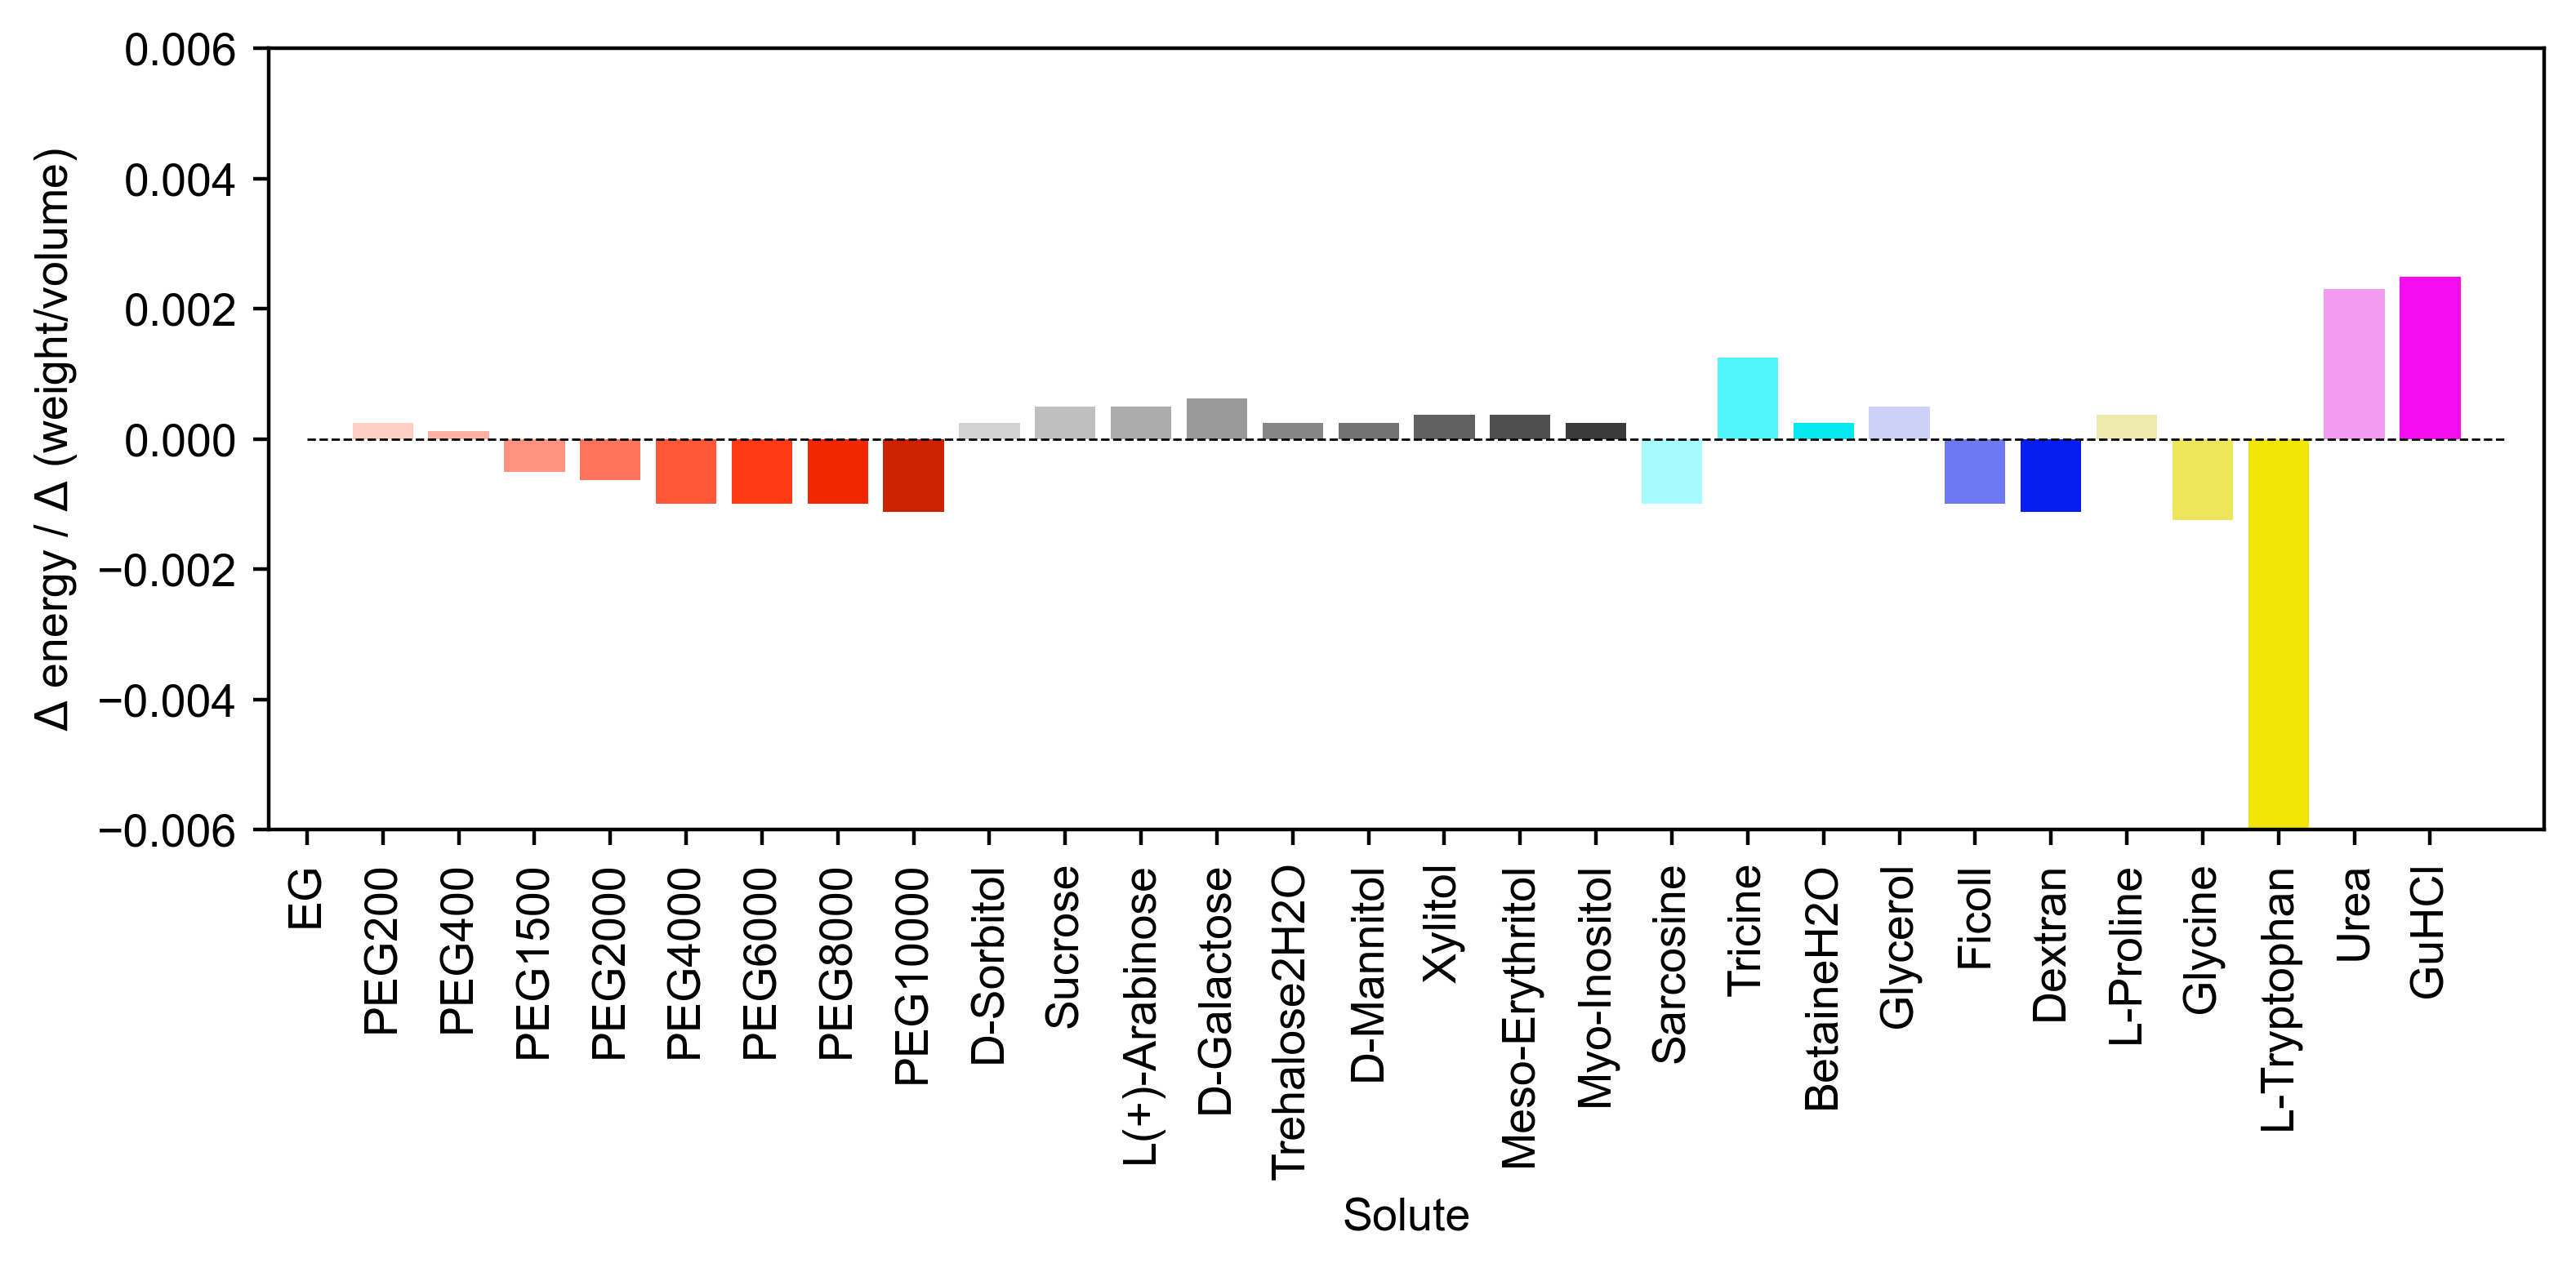

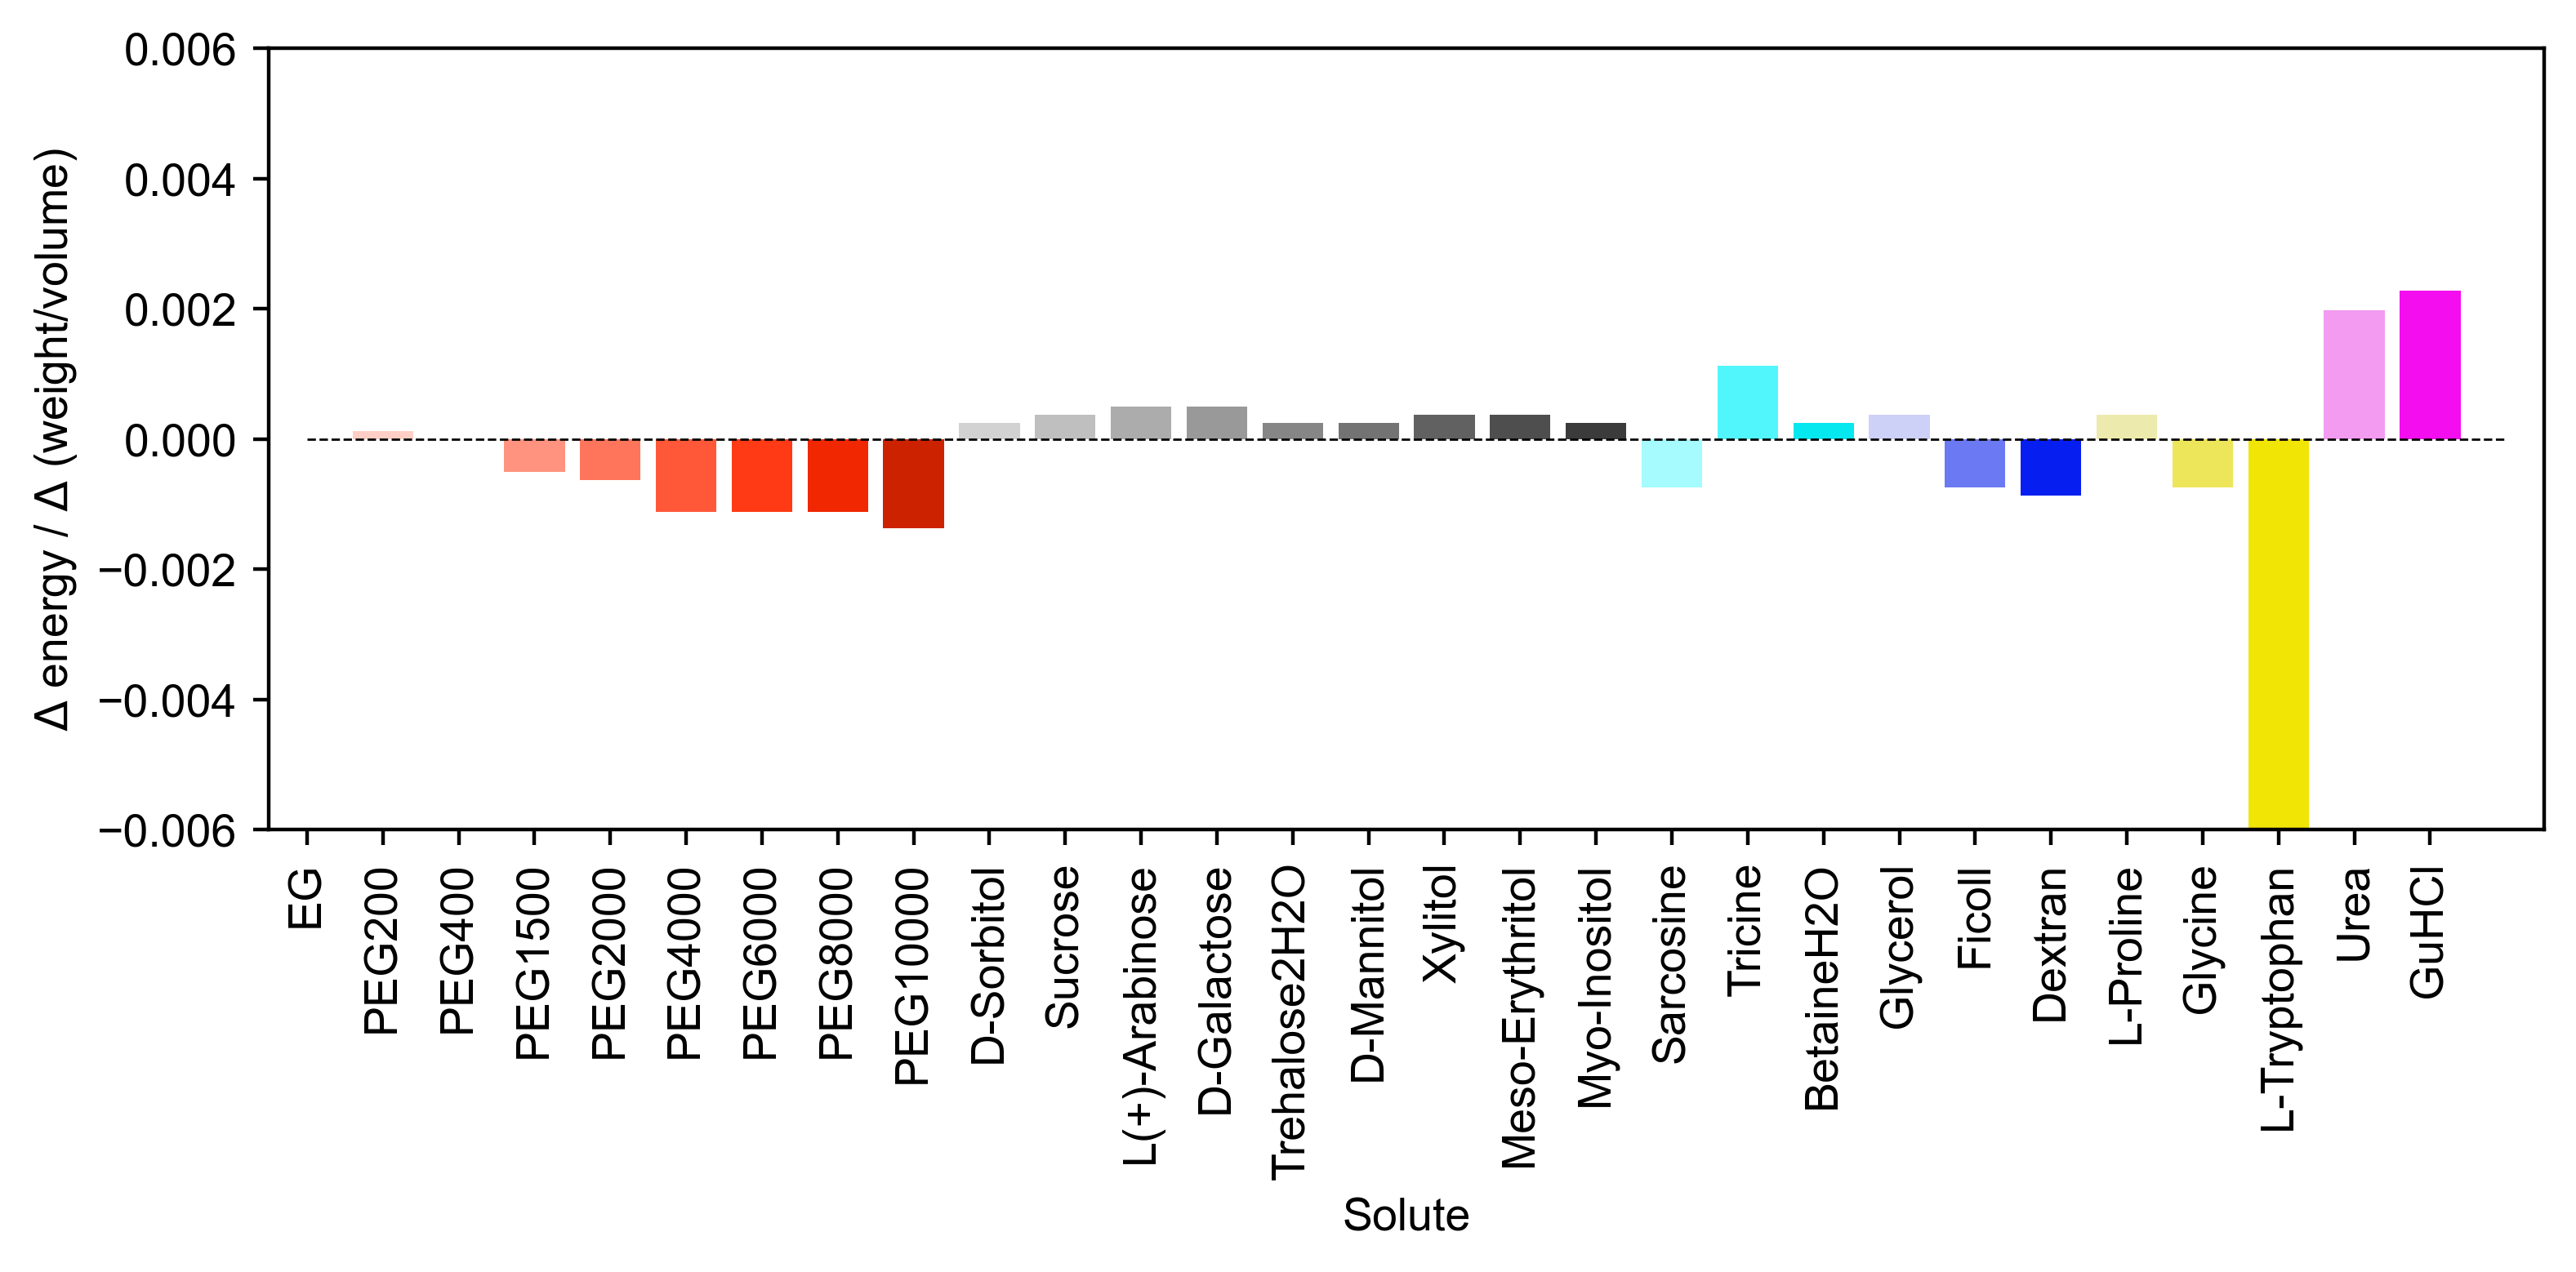

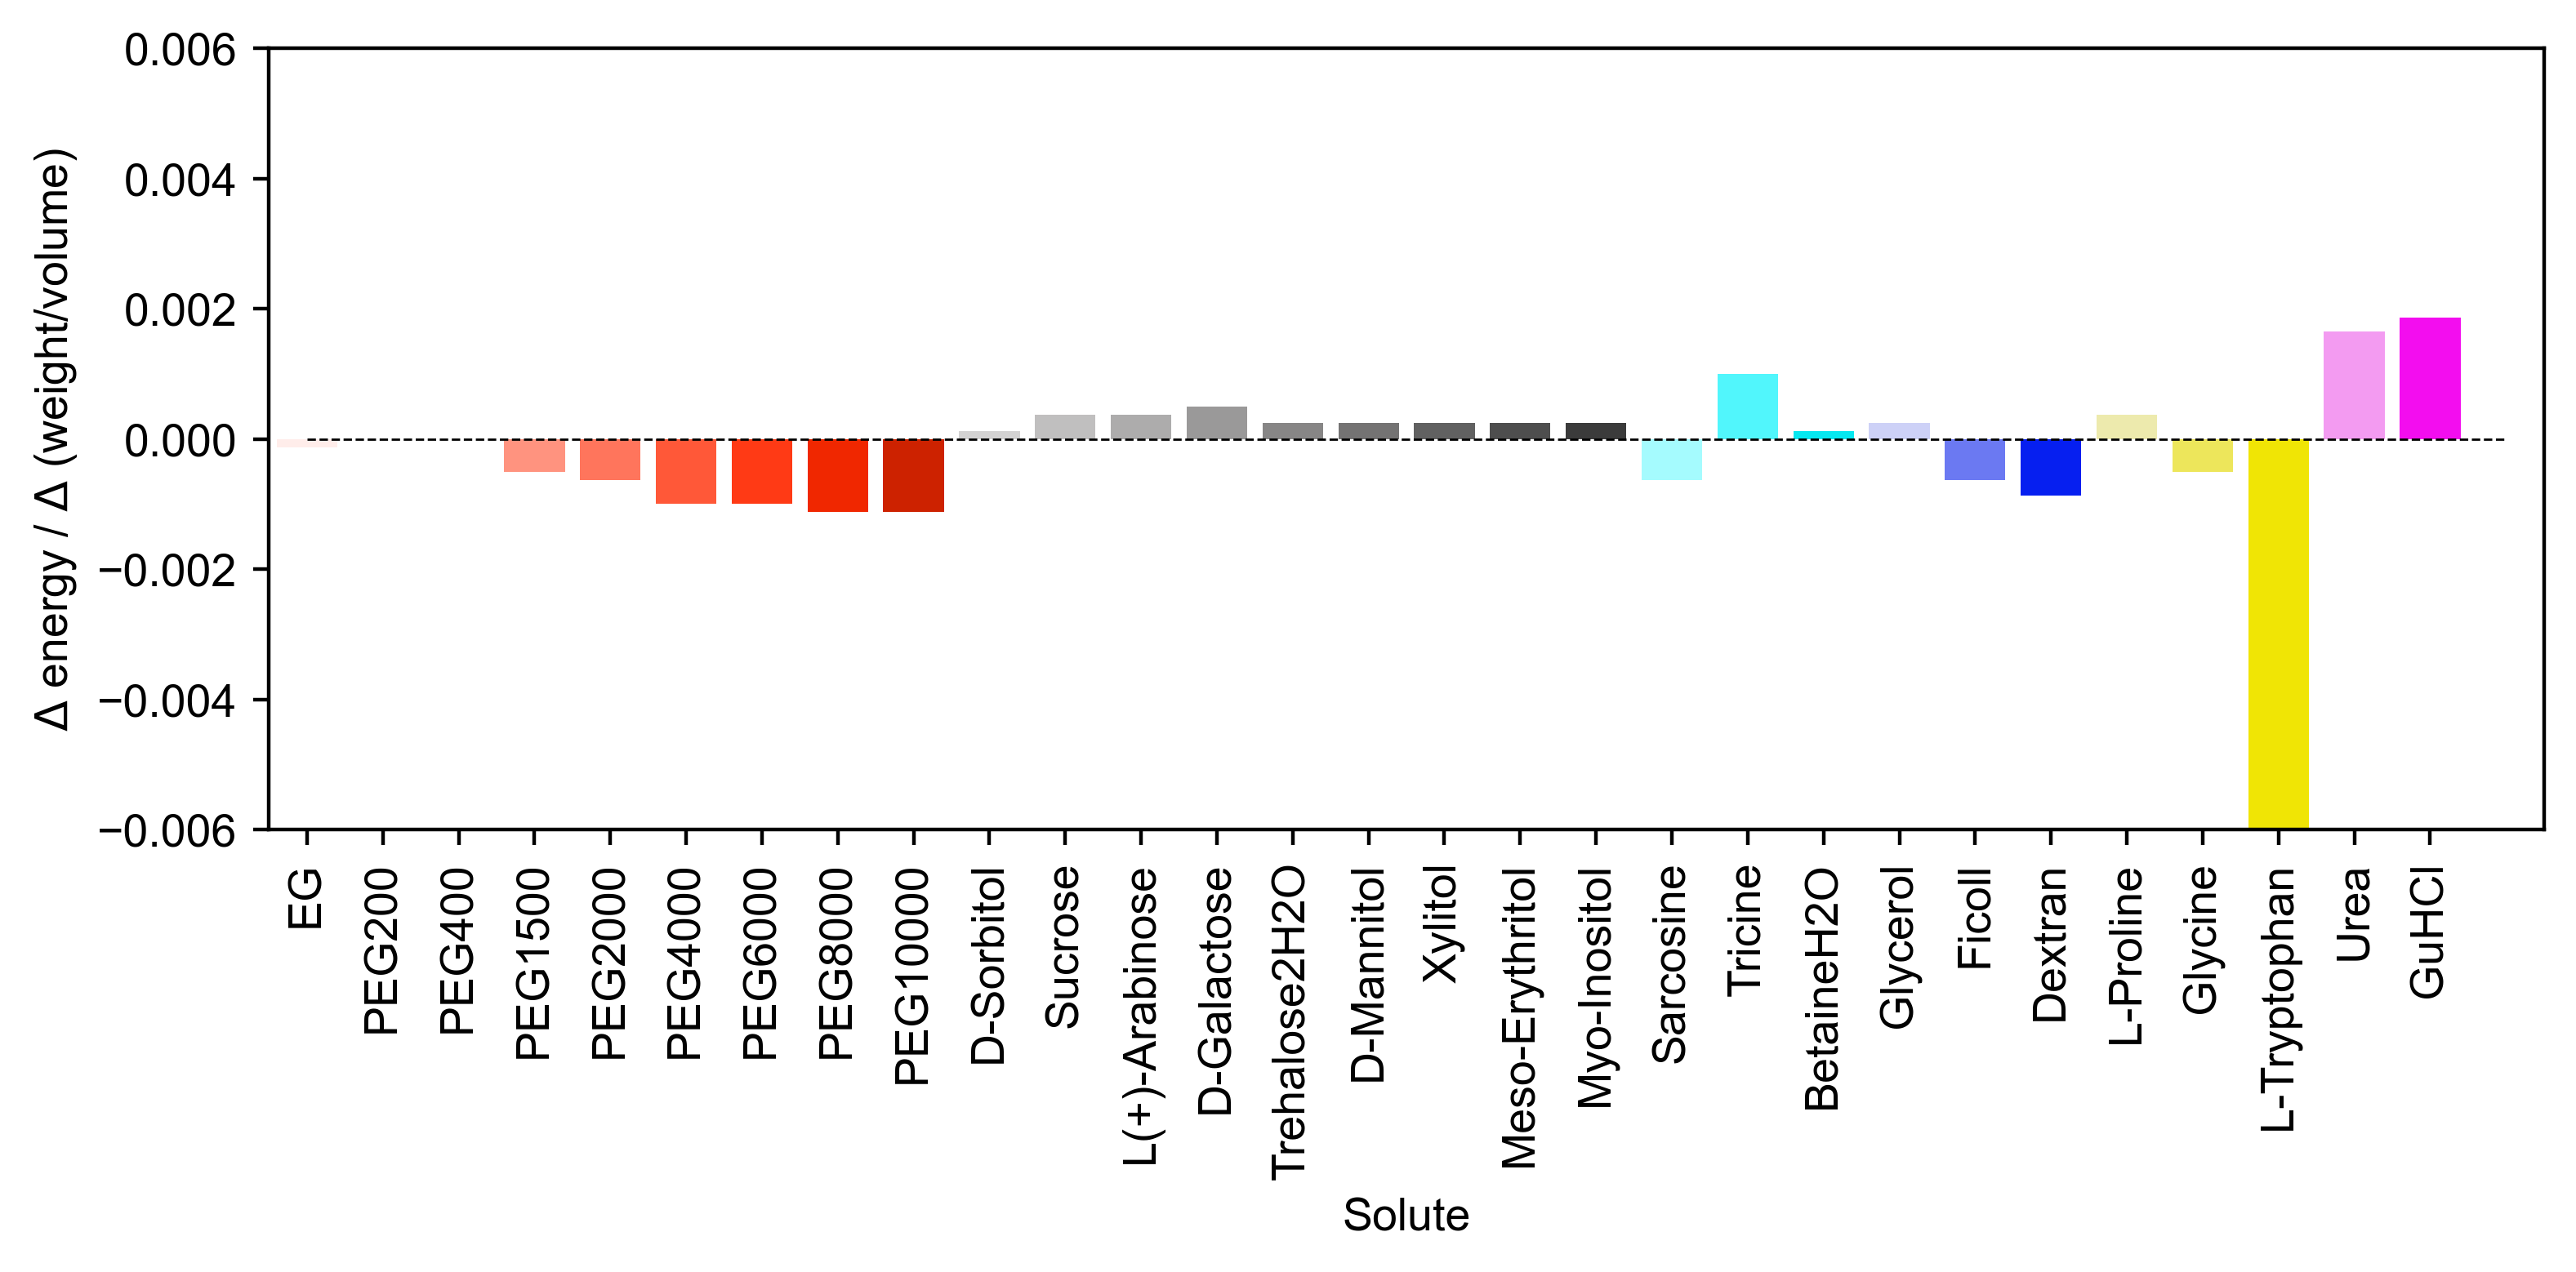

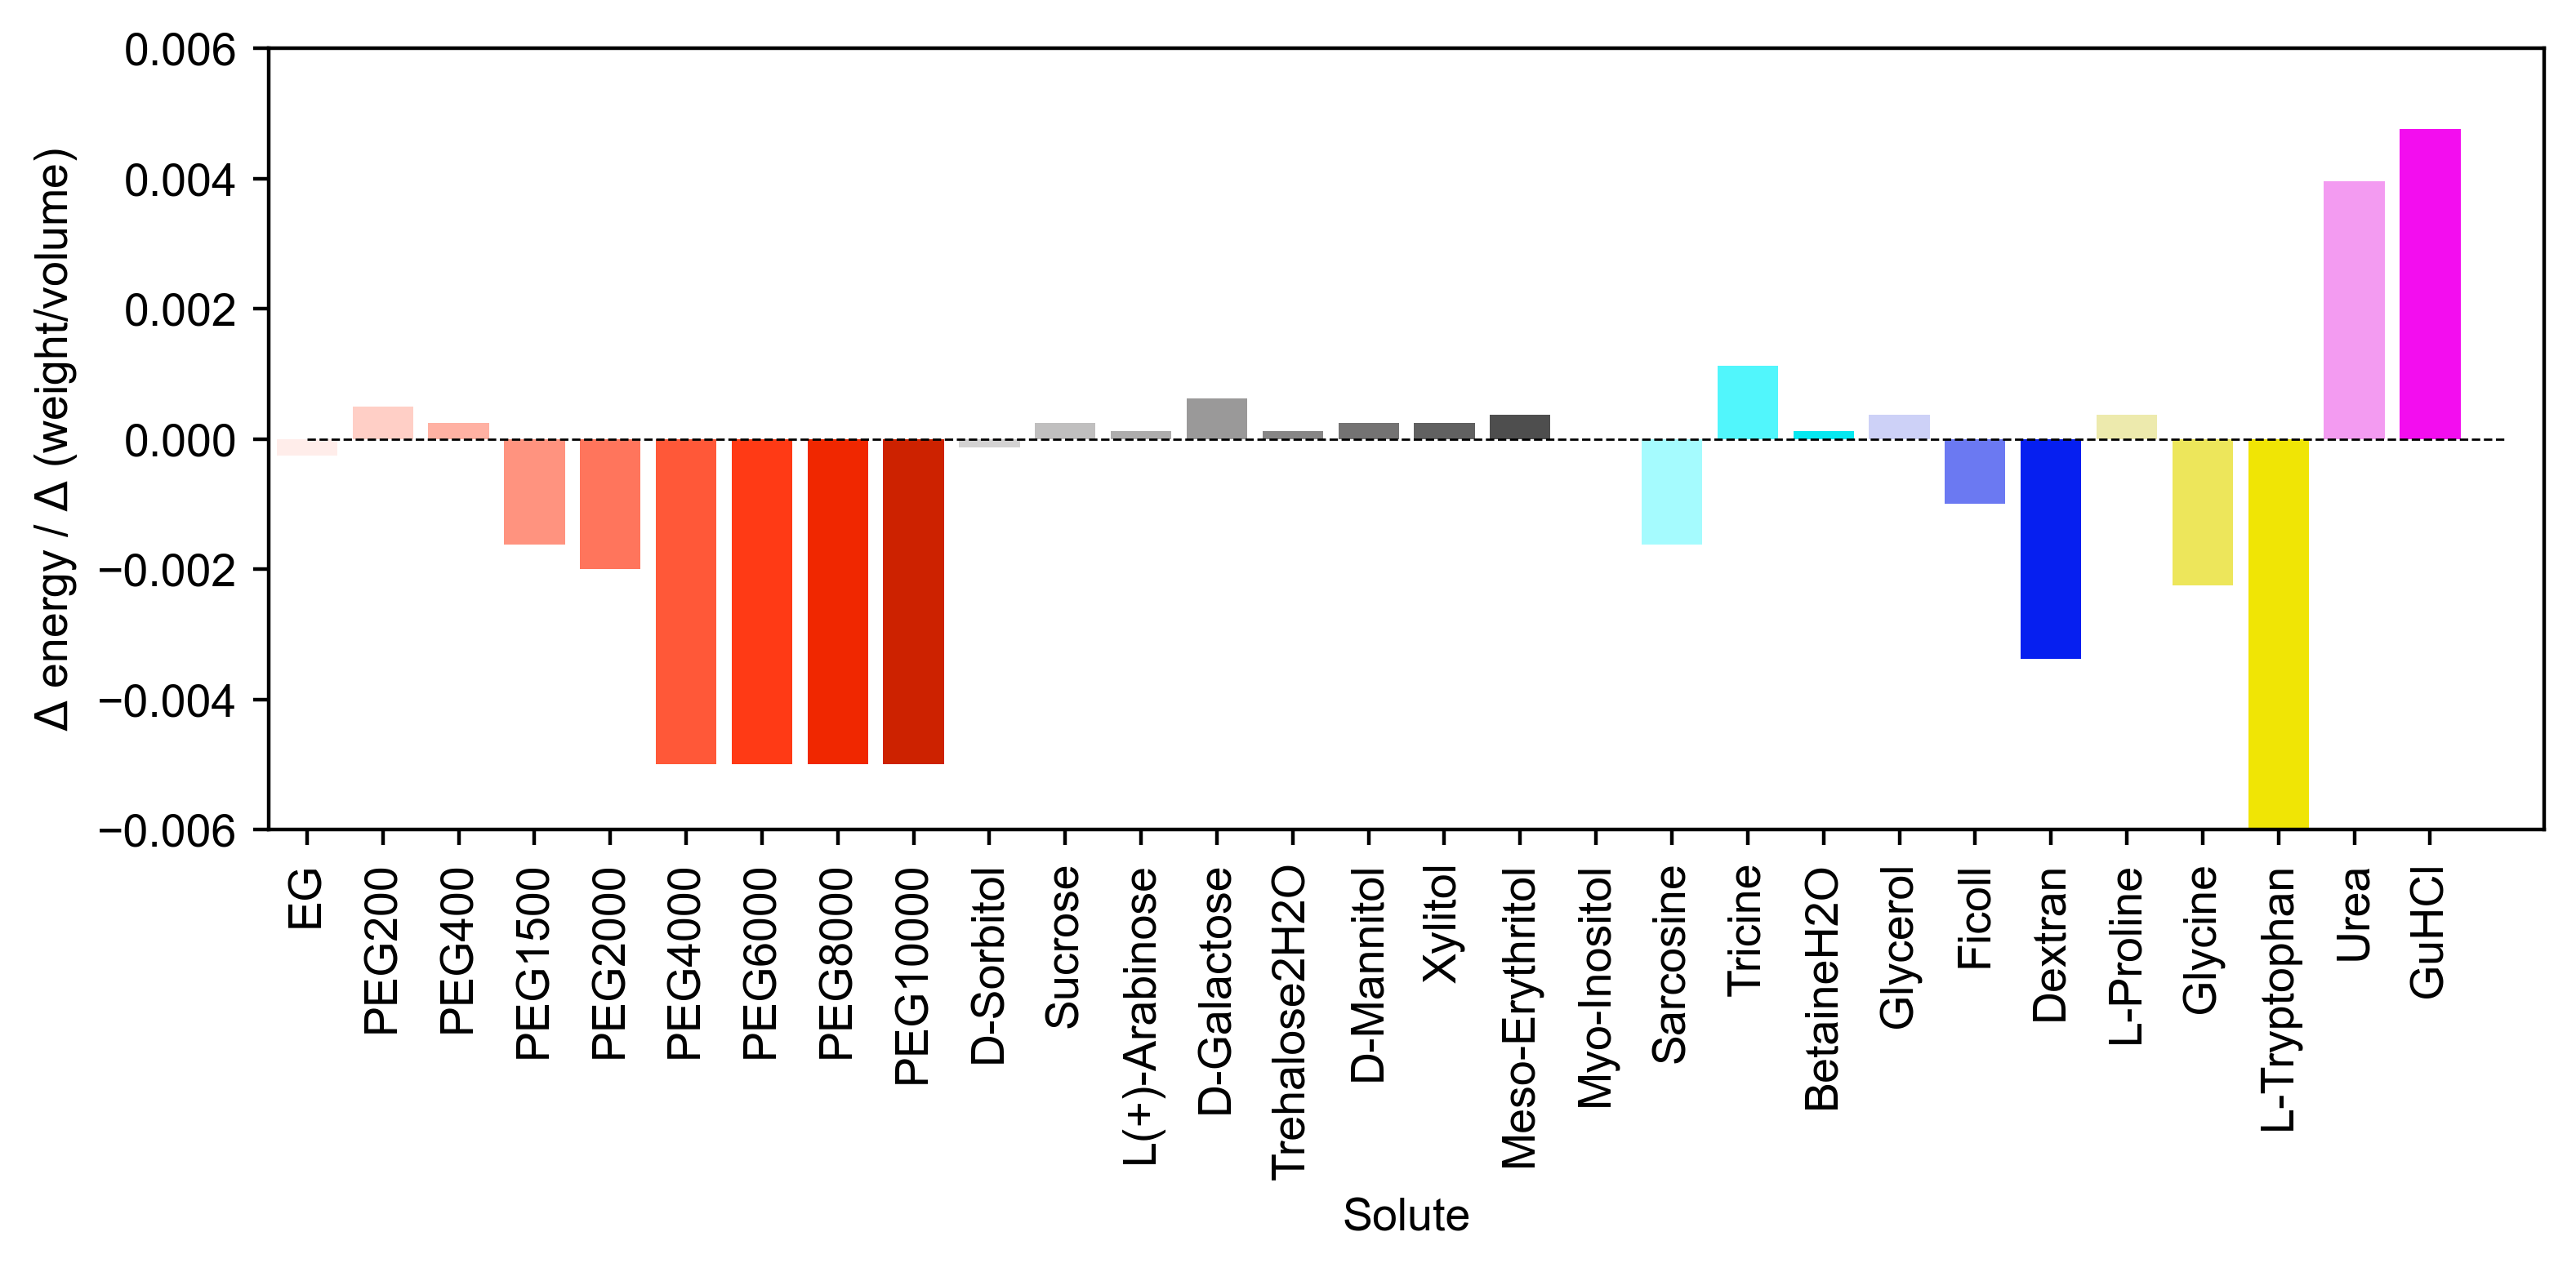

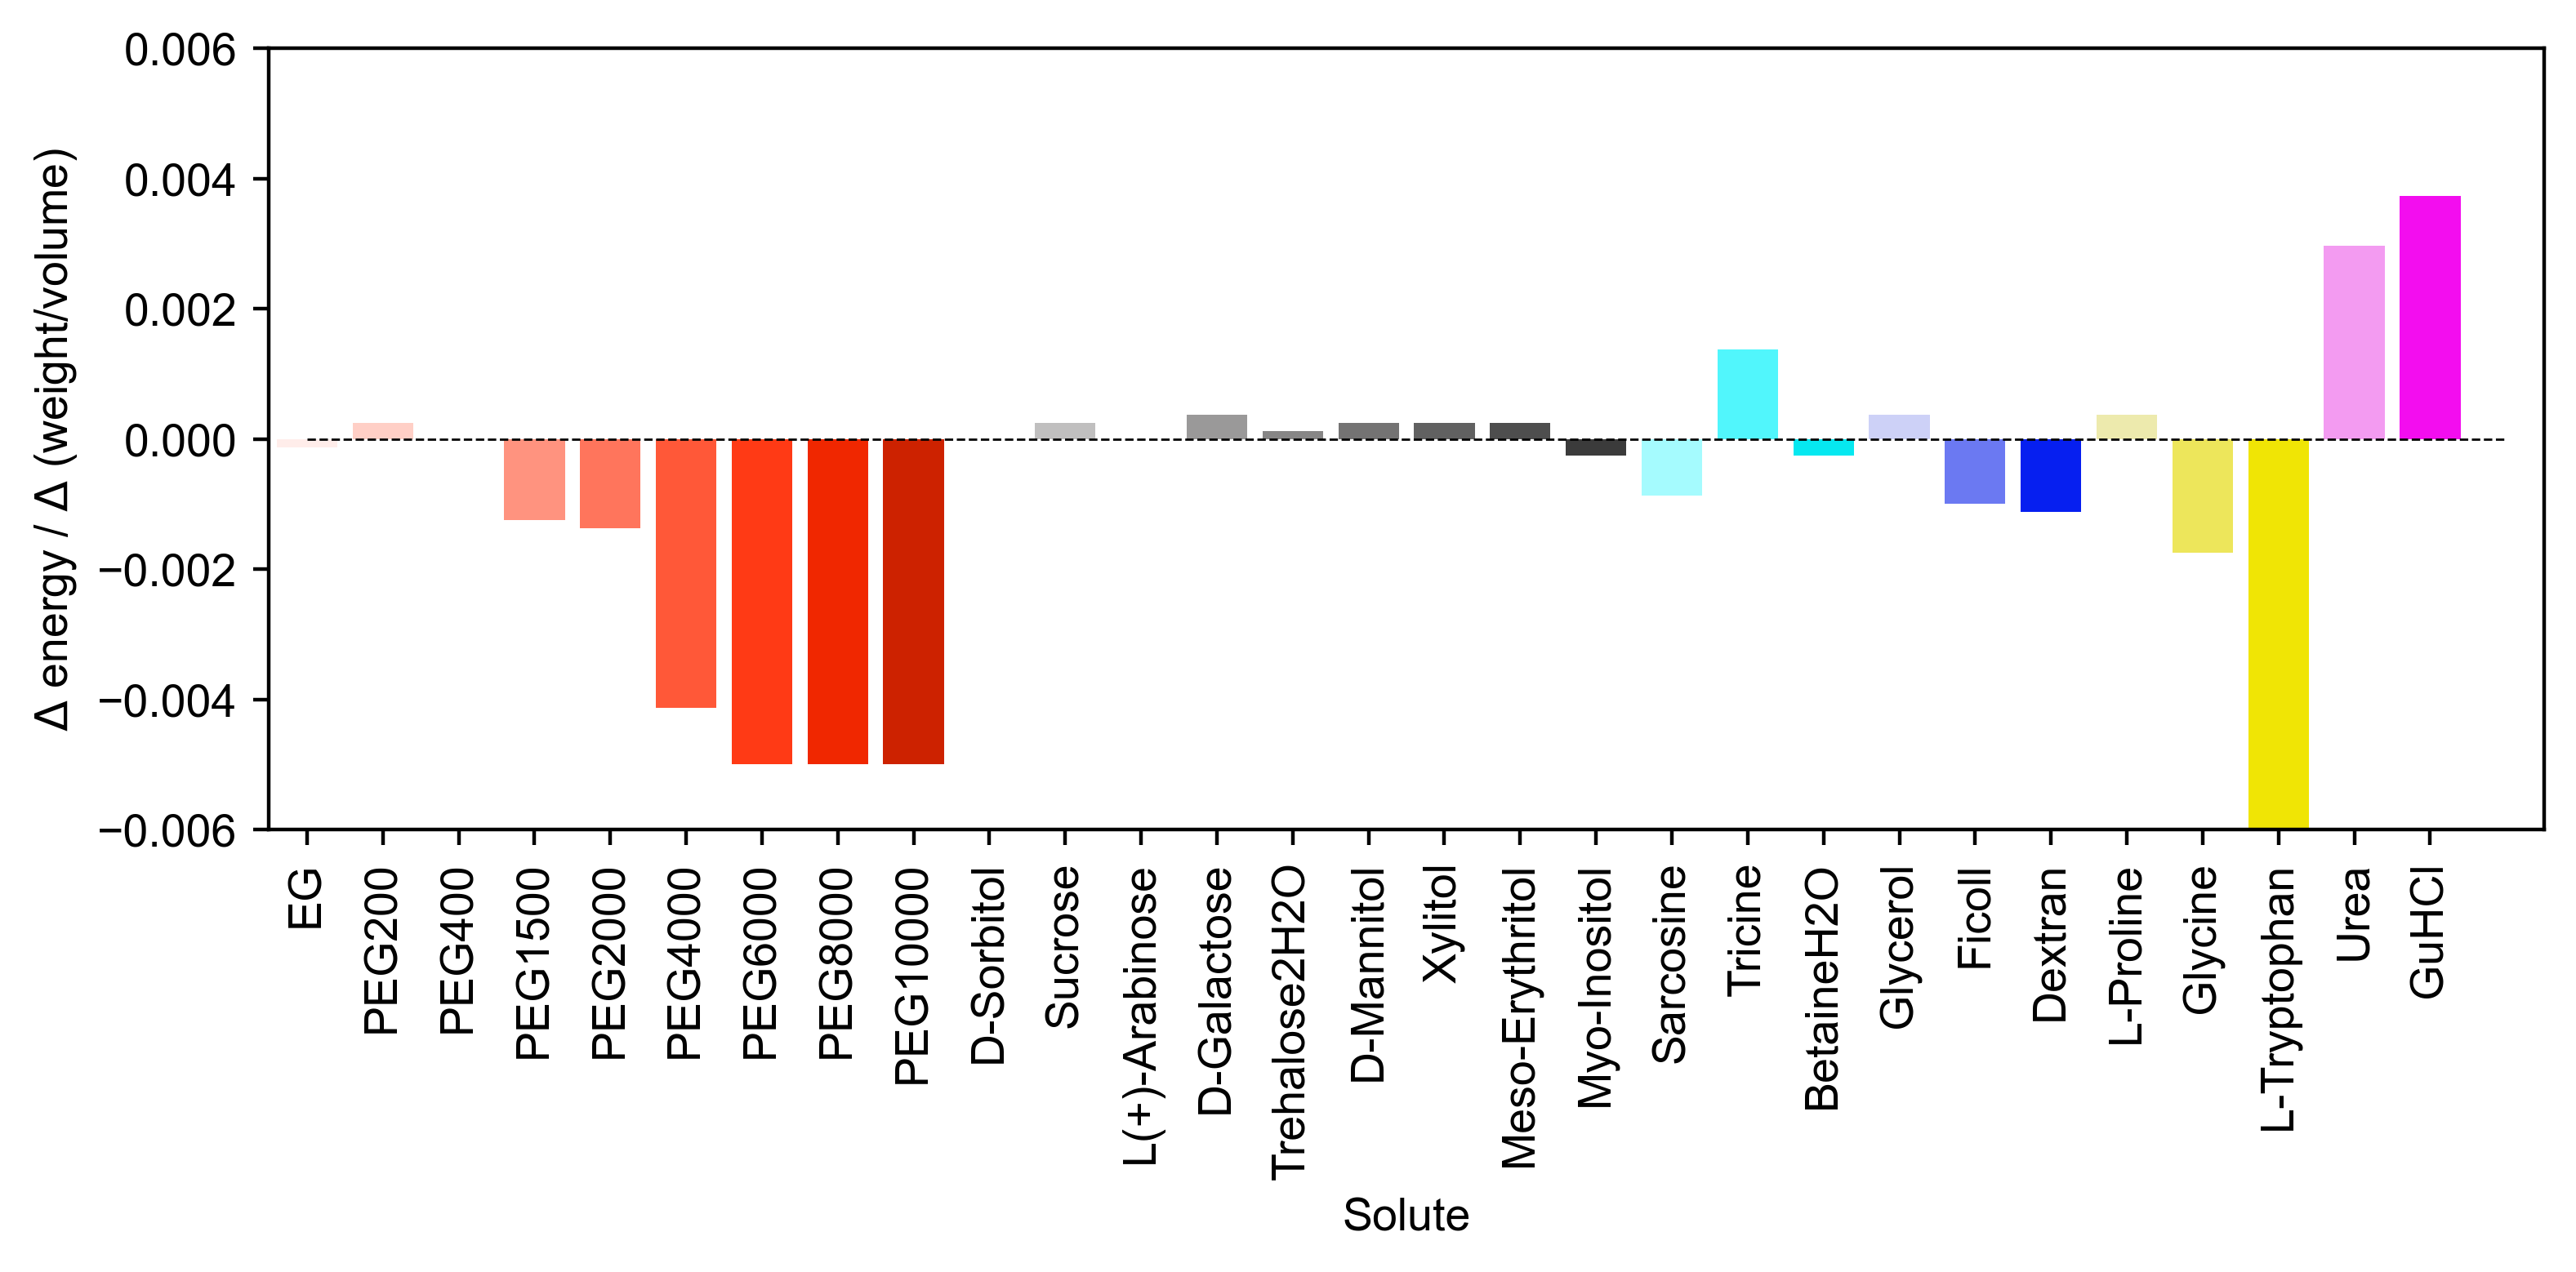

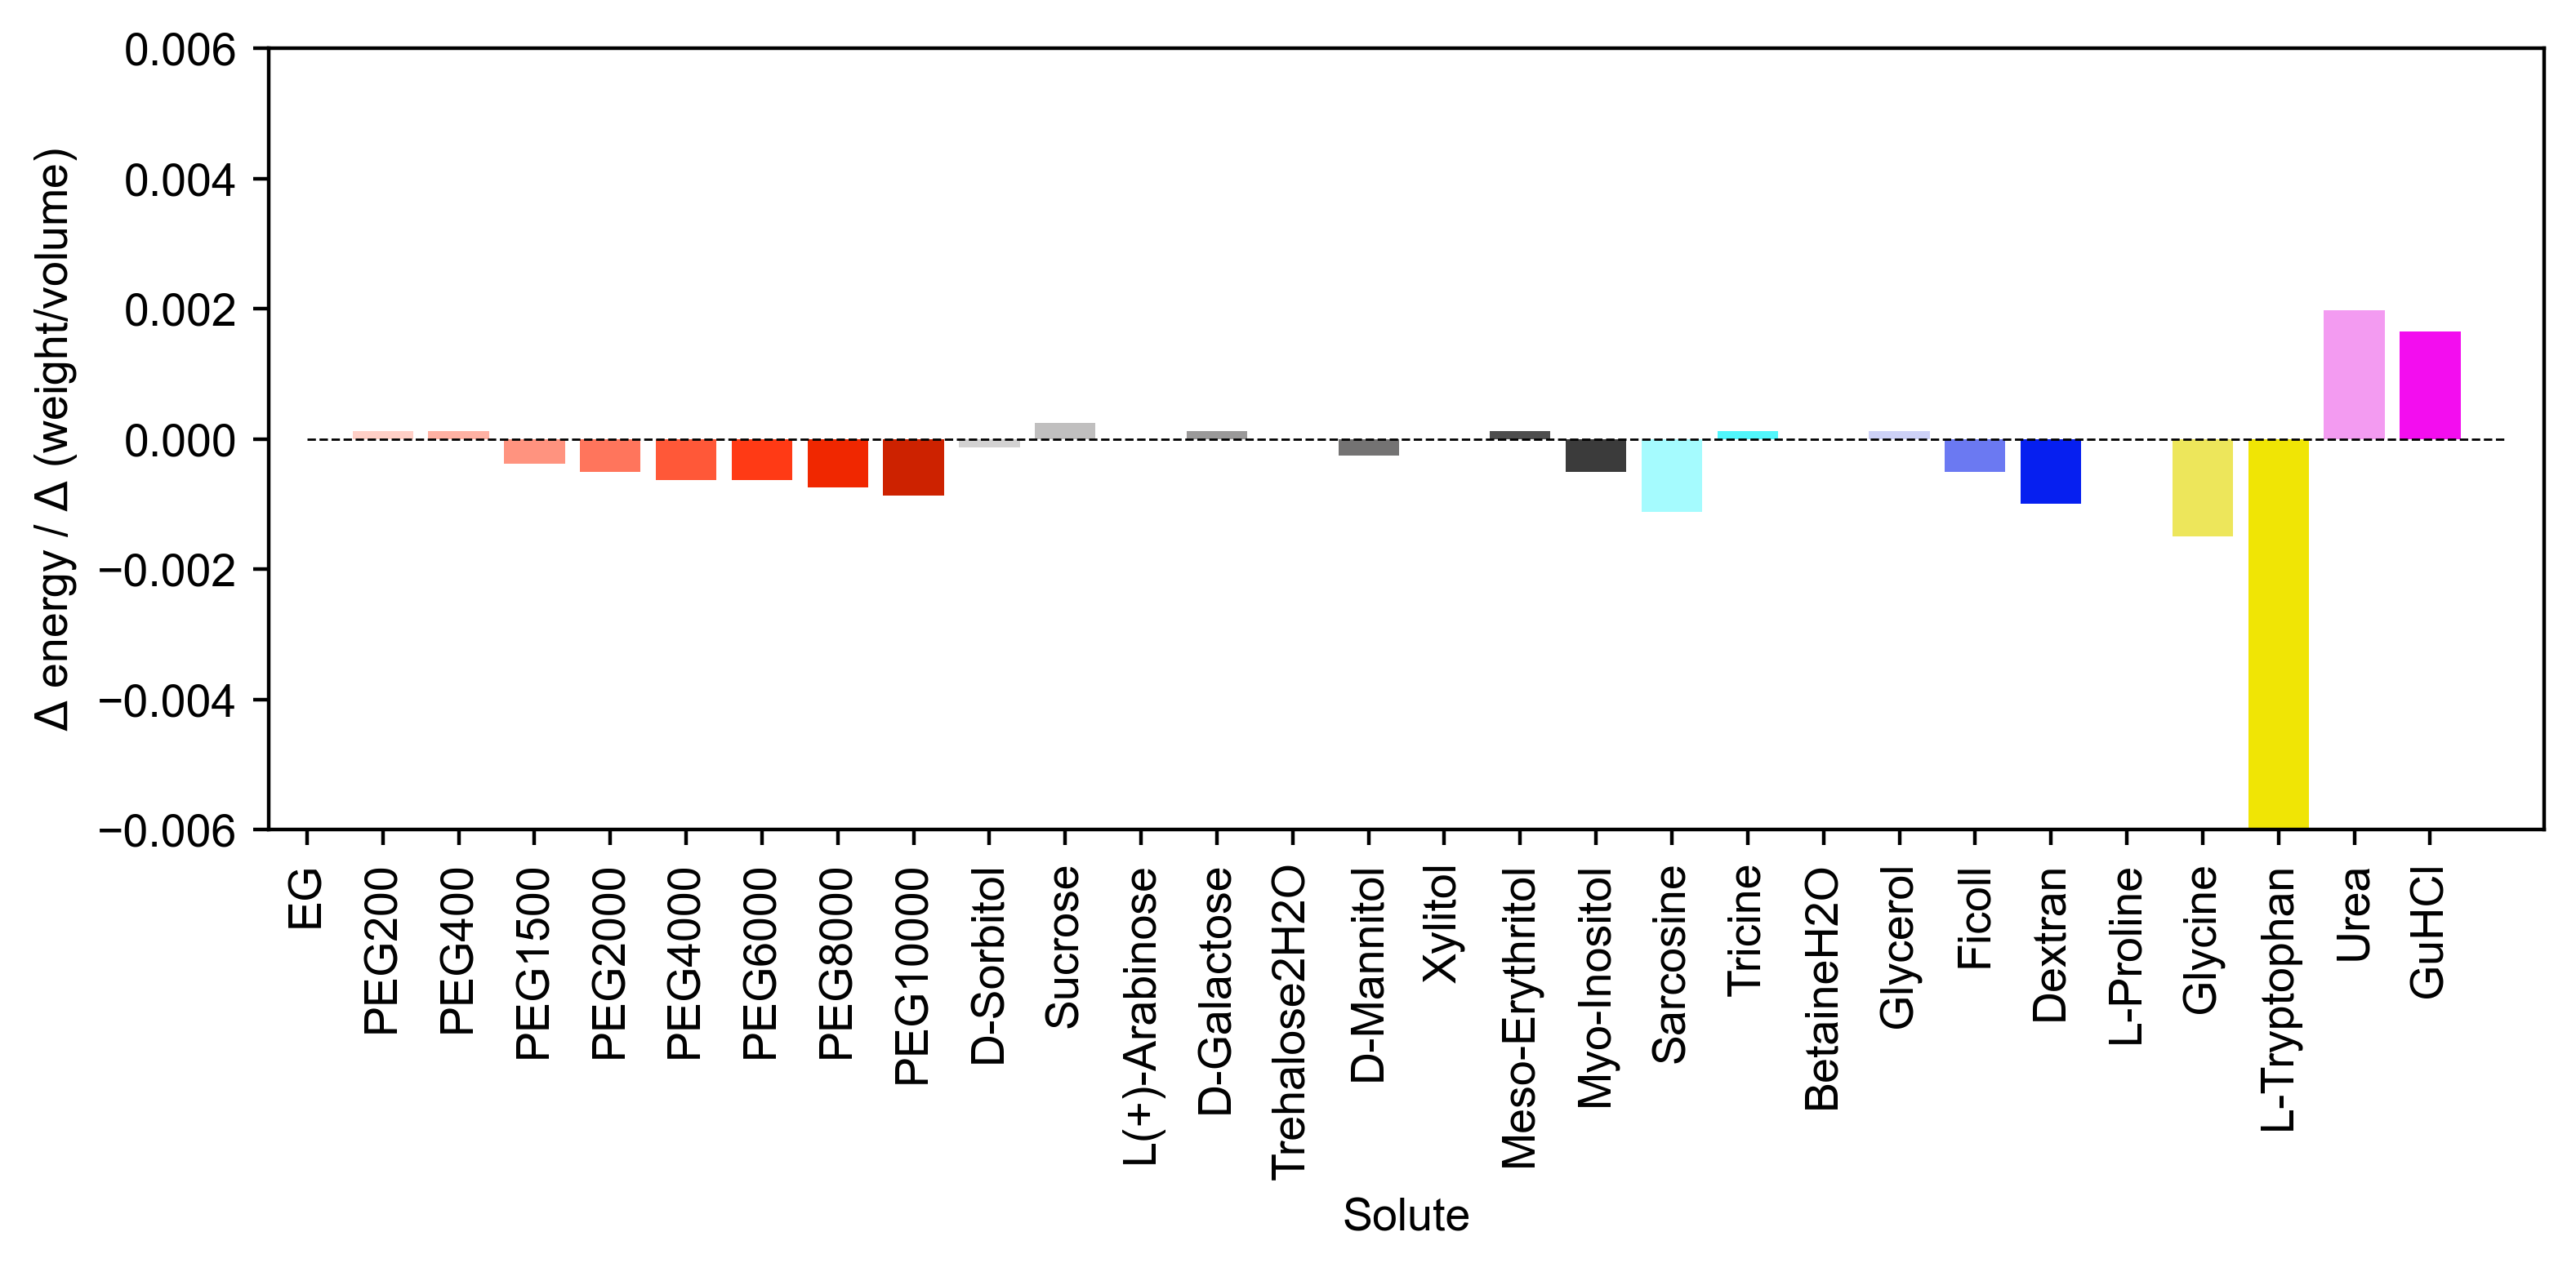

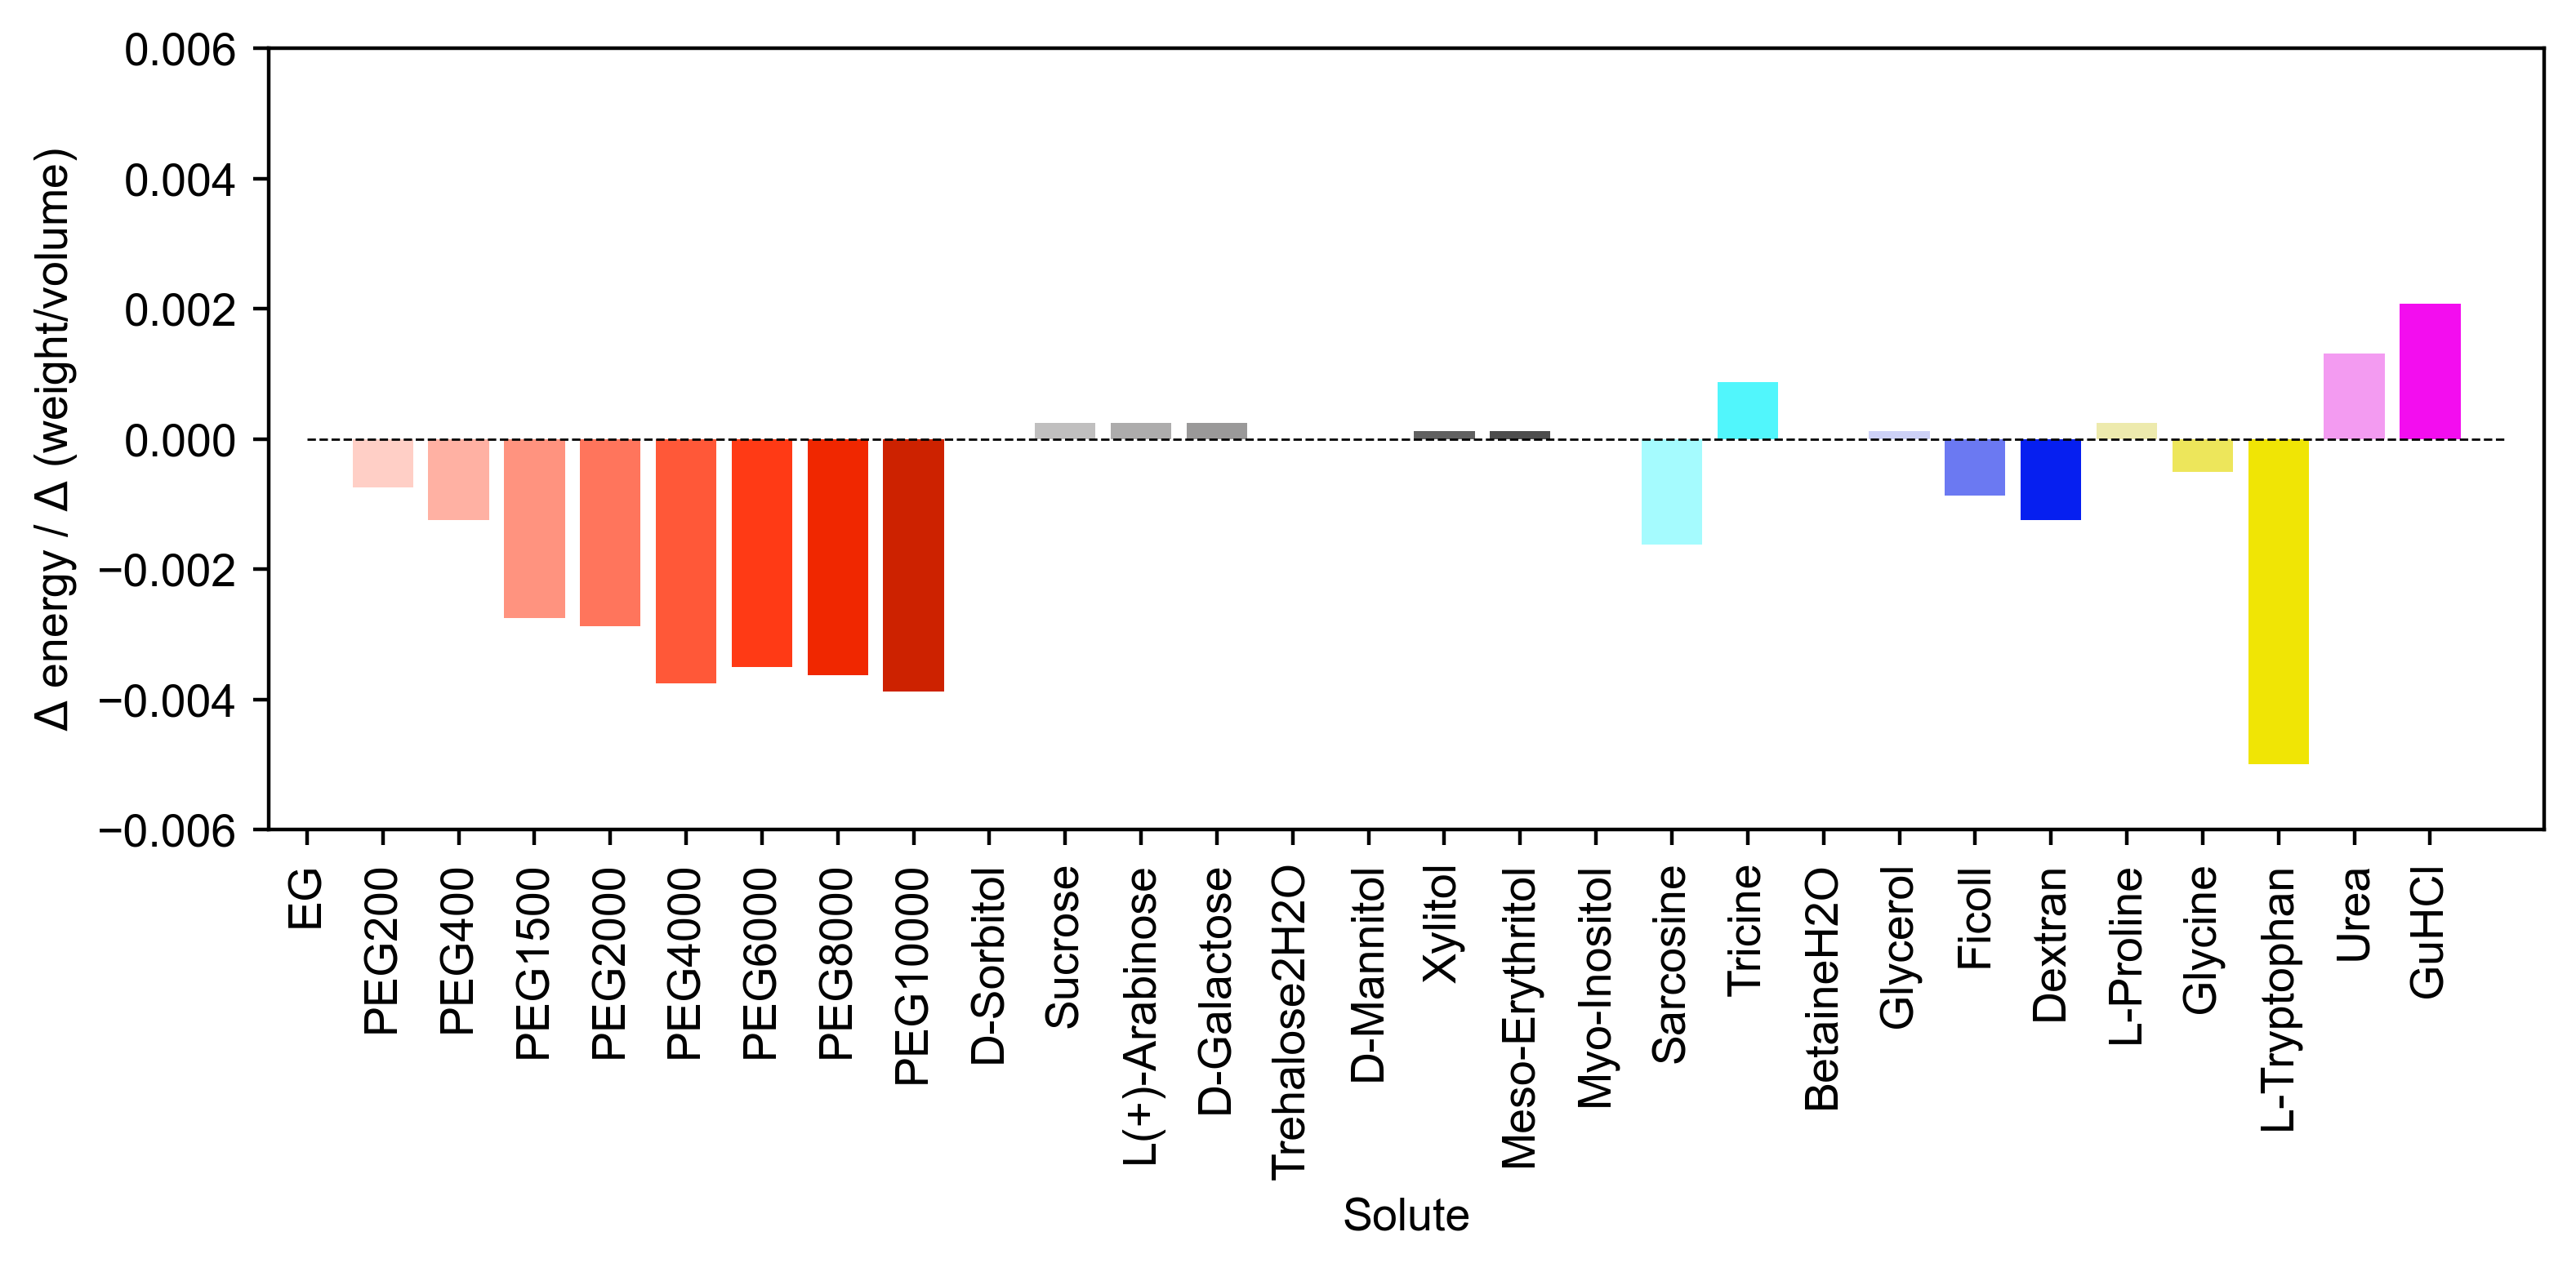

In [18]:
from colour import Color

# flag that sets how big the actual figure is!
scalar = 0.8

# define grouping of solutes
PEGS = ['EG','PEG200', 'PEG400', 'PEG1500', 'PEG2000', 'PEG4000', 'PEG6000', 'PEG8000','PEG10000'] 
CARBS = ['D-Sorbitol', 'Sucrose', 'L(+)-Arabinose', 'D-Galactose', 'Trehalose2H2O', 'D-Mannitol', 'Xylitol', 'Meso-Erythritol', 'Myo-Inositol']
BUFFER = ['Sarcosine', 'Tricine','BetaineH2O']
CROWDERS = ['Glycerol', 'Ficoll', 'Dextran']
AA = ['L-Proline', 'Glycine', 'L-Tryptophan']
DENAT = ['Urea','GuHCl']

ind = np.arange(len(all_solvents_no_salt))


# define colours for each of those groups
COLOR_SETS = [["#FFEDEA", "#CD2200"],
              ["#D3D2D2", "#3B3B3B"],
              ["#A5FBFE", "#06E8F0"],
              ["#CDD1F7", "#061FF0"],
              ["#EDEAAD", "#F0E505"],
              ["#F39BF1", "#F30DEF"]]


for protein in idr_lens:
    
    # get IDR length
    L = idr_lens[protein]

    # compute the range of energies we'll use to fit against. NOTE we're going to 
    # perform fitting in the inter-chain interaction limit 
    energy_c2g = np.arange(-0.5, 0, 0.001)

    # build the length-dependent analytical model we're going fit against
    chi_c2g = energytochi(energy_c2g, L, PREFACTOR)
    
    print("%s => -0.4: %3.3f" % (protein, chi2nu(-0.4,L,PREFACTOR)))
    print("%s => -0.2: %3.3f" % (protein, chi2nu(-0.2,L,PREFACTOR)))
    print("%s => +0.2: %3.3f" % (protein, chi2nu(0.2,L,PREFACTOR)))
    print("%s => +0.4: %3.3f" % (protein, chi2nu(0.4,L,PREFACTOR)))

    # first fit for start (buffer) - note Ficoll is arbitrarily chosen
    # just need a solute where at 0 mol of that solute the conditions
    # are native buffer
    chi_start = all_data[protein]['Ficoll'].transpose()[1][0]
    
    # fit energy val to this chi value
    start_energy = fit_start_energy(chi_start, L)

    delta_energy_delta_weightvol = []    
    figure(num=None, figsize=(10*scalar, 8*scalar), dpi=120, facecolor='w', edgecolor='k')
    
    # figure out solvent offset fo this protein
    tmp = all_data[protein]['Ficoll'].transpose()[1]
    v = fit_exp_chi_to_energy(tmp, L, start_energy)

    # first plot the analytical model
    plt.plot(energy_c2g-v[1][0], chi_c2g,'k', linewidth=2)
    maxval = (energy_c2g-v[1][0])[-1]
    
    idx = -1

    all_names_in_order = []
    all_colors_in_order = []
    
    # cycle over each of the different solution groups...
    for NAMES in [PEGS, CARBS, BUFFER, CROWDERS, AA, DENAT]:    
        idx=idx+1
    
        start_color = Color(COLOR_SETS[idx][0])
        colors = list(start_color.range_to(Color(COLOR_SETS[idx][1]), len(NAMES)))
    
        color_idx=0
        for s in NAMES:  
            all_names_in_order.append(s)
            all_colors_in_order.append(colors[color_idx].get_hex())
                
            tmp = all_data[protein][s].transpose()[1]
        
            weight_volume_delta = all_data[protein][s].transpose()[0][2] - all_data[protein][s].transpose()[0][1]
        
            v = fit_exp_chi_to_energy(tmp, L, start_energy)
        
            delta_energy_delta_weightvol.append(v[0]/weight_volume_delta)
            
            # zero-ed energy valus note we divide by 2 to convert into solvent:solute energy but keep as negative
            # because it plots in the more intuitive  direction (fix in illustrator after)
            zeroed_energy_vals = (v[1] - v[1][0])
            
            plt.plot(zeroed_energy_vals , tmp,'-o',alpha=0.9, color=colors[color_idx].get_hex(), mec='k', mew='0.8', markersize=8, linewidth=1)
            color_idx = color_idx +1 

        
    ### finish up plotting fit
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.plot([-0.2, maxval], [tmp[0], tmp[0]],'k--', linewidth=0.5)
    

    #plt.legend(['M'] + all_names_in_order, loc='upper left')
    plt.xlim([-0.2, maxval])
    plt.xlabel(r'$\Delta$ chain:solvent interaction (kT)', fontsize=20)
    plt.ylabel(r'$\chi$', fontsize=20)
    plt.savefig('figures/experimental_fit/fit_curve_%s.pdf'%(protein))
    plt.close()
    
    
    

    alt=[]
    for i in all_names_in_order:
        alt.append(str(i.strip())[0:5])

    figure(num=None, figsize=(8, 4), dpi=200, facecolor='w', edgecolor='k')

    plt.plot([0,len(delta_energy_delta_weightvol)], [0,0],'--k',linewidth=0.5)
    plt.bar(list(range(len(delta_energy_delta_weightvol))), delta_energy_delta_weightvol, color=all_colors_in_order)
    plt.xticks(ind, all_names_in_order)
    plt.xlim([-0.5,29.5])
    plt.ylim([-0.006, 0.006])
    plt.xticks(rotation=90)
    plt.ylabel(r'$\Delta$ energy / $\Delta$ (weight/volume)')
    plt.xlabel('Solute')
    plt.tight_layout()
    plt.savefig('figures/experimental_fit/sequence_specific_scalar_%s.pdf'%(protein))
    
    
    
    